# Projet (Online_shop 2024)

 ## Objectif : 
 ## Analyse global des performances 
### 1_Préparation et analyse exploratoir des données
### 2_Prédiction des tendance des ventes et durée de livraison

In [88]:
# Chargement des modules et importation des bibliothèques

import pandas as pd
import numpy  as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LinearRegression
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error, r2_score

## Importer nos données 

In [91]:
# Charger le dataset depuis la base de donnée online_shop
import mysql.connector

# Connexion à MySQL
conn = mysql.connector.connect(
    host="localhost",       # serveur MySQL
    user="root",            # nom d'utilisateur MySQL
    password="..............",    # mot de passe MySQL
    database="online_shop"  # base de données
)

# Création du curseur
cursor = conn.cursor()
# Requête SQL pour récupérer la table ou la vue
query = "SELECT * FROM online_analysis"  # nom de ta table/vue `online_analysis`
# Exécution de la requête
cursor.execute(query)
# Récupération des résultats dans un DataFrame Pandas
df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
# Fermeture de la connexion
cursor.close()
conn.close()
# Affichage des 3 premières lignes
print(df.head(3))

   order_item_id  order_id  product_id  customer_id last_name  \
0           1129         1        1896         8002  Victoria   
1          18432         1        1896         8002  Victoria   
2          14818         2         534         5097     Bruce   

  price_at_purchase  quantity   amount rating        category  product_name  \
0             96.99         1    96.99   None     Electronics    4K Monitor   
1             22.73         3    68.19   None     Electronics    4K Monitor   
2            831.45        10  8314.50   None  Home & Kitchen  Air Purifier   

  transaction_status carrier shipment_status            supplier_name  \
0          Completed     UPS         Pending      Unified Trading Co.   
1          Completed     UPS         Pending      Unified Trading Co.   
2          Completed     DHL       Delivered  Modern Tech Enterprises   

  order_date shipment_date delivery_date  
0 2024-10-10    2024-10-13    2024-10-14  
1 2024-10-10    2024-10-13    2024-10-14  


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_item_id       20000 non-null  int64         
 1   order_id            20000 non-null  int64         
 2   product_id          20000 non-null  int64         
 3   customer_id         20000 non-null  int64         
 4   last_name           20000 non-null  object        
 5   price_at_purchase   20000 non-null  object        
 6   quantity            20000 non-null  int64         
 7   amount              20000 non-null  object        
 8   rating              1529 non-null   object        
 9   category            20000 non-null  object        
 10  product_name        20000 non-null  object        
 11  transaction_status  20000 non-null  object        
 12  carrier             20000 non-null  object        
 13  shipment_status     20000 non-null  object    

## Analyse du dataset
    Taille du dataset : 20 000 entrées, couvrant 18 colonnes.
    Types de données  : 
    valeurs numériques (int64, float64), 
    Des dates (datetime64[ns]), et des textes (object) pour certaines catégories et statuts. 
    Variables financières (price_at_purchase, amount) : en object, à convertir en float64 pour une analyse correcte.
    Variables product_name, supplier_name, category, transaction_status, carrier et shipment_status à convertir en type categorie, pour une meilleur performance.           
    Suivi des commandes : Les dates order_date, shipment_date, delivery_date permettront d'analyser les délais de livraison.
    Valeurs manquantes  : La colonne rating contient seulement 1 529 valeurs, donc elle a des valeurs NaN qui doivent être gérées : pas note en valeur de (0) et conversion en int pour calculer la moyenne.

In [93]:
# Calcul du nombre de valeurs uniques pour chaque colonne
unique_counts = df.nunique()

# Affichage des résultats
print("Nombre de valeurs uniques par colonne :")
print(unique_counts)

Nombre de valeurs uniques par colonne :
order_item_id         20000
order_id              15000
product_id             1997
customer_id           10000
last_name                70
price_at_purchase     16399
quantity                 10
amount                17250
rating                    5
category                  4
product_name             50
transaction_status        3
carrier                   3
shipment_status           4
supplier_name            25
order_date              366
shipment_date           369
delivery_date           373
dtype: int64


# 1. Préparation des données &  Analyse exploratoire

## A_Traitement et nettoyage des données

In [10]:
# Vérifier les doublans 
# Vérification des doublons dans toutes les colonnes
duplicate_rows = df[df.duplicated()]
# Affichage du nombre total de doublons
print(f"Nombre de doublons détectés : {len(duplicate_rows)}")
# Affichage d'un aperçu des doublons
print("\n Aperçu des doublons :")
print(duplicate_rows.head())
# Optionnel : Suppression des doublons
#df_cleaned = df.drop_duplicates()
#print(f"\n Nouveau nombre d'enregistrements après suppression : {len(df_cleaned)}")

Nombre de doublons détectés : 0

 Aperçu des doublons :
Empty DataFrame
Columns: [order_item_id, order_id, product_id, customer_id, last_name, price_at_purchase, quantity, amount, rating, category, product_name, transaction_status, carrier, shipment_status, supplier_name, order_date, shipment_date, delivery_date]
Index: []


In [11]:
# Traitement des valeurs manquantes 
print(df['rating'].mean().round(2))
print(df['rating'].count())

2.75
1529


In [183]:
# Conversion en type numérique 
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['rating'] = df['rating'].fillna(df['rating'].mean())

In [185]:
# Vérification après modification 
print(df['rating'].mean().round(2))
print(df['rating'].count())

2.75
20000


In [167]:
# Conversion des types en numérique 
df['price_at_purchase'] = pd.to_numeric(df['price_at_purchase'], errors='coerce')
df['amount']            = pd.to_numeric(df['amount'], errors='coerce')

In [169]:
# Conversion des types en catégorielles 
cols_to_convert = ['product_name', 'supplier_name', 'category', 'transaction_status', 'carrier', 'shipment_status']
df[cols_to_convert] = df[cols_to_convert].astype('category')

In [171]:
# Conversion des dates 
date_cols = ['order_date', 'shipment_date', 'delivery_date']
df[date_cols] = df[date_cols].apply(pd.to_datetime, errors='coerce')
# Ajout de la colonne delivery_delay (pour détecter le délais)
df['delivery_delay'] = (df['delivery_date'] - df['shipment_date']).dt.days

## B_Analyse exploratoire

## Analyser les KPI 

In [19]:
# Calcul des KPI
total_quantite        = df['quantity'].sum()           # 0. Quantité total des ventes
total_revenue         = df['amount'].sum()             # 1. Chiffre d'affaires total
average_sales         = df['amount'].mean()            # 2. Vente moyenne par transaction
total_transactions    = df['order_item_id'].nunique()  # 3. Nombre total de transactions
average_price         = df['price_at_purchase'].mean() # 4. Moyen de prix de commande
average_delivery      = (df['delivery_date'] - df['order_date']).mean().days      # 5. Délai moyen de livraison à la prise de la commande
average_shiping       = (df['delivery_date'] - df['shipment_date']).mean().days   # 6. Délai moyen de livraison à l' expédition
sales_by_category     = df.groupby('category', observed=True)['amount'].sum()     # 7. Répartition des ventes par catégorie
peak_positive         = df.groupby(df['order_date'].dt.to_period("M"))['amount'].sum().idxmax()  # 8. Mois avec le pic de ventes
peak_negative         = df.groupby(df['order_date'].dt.to_period("M"))['amount'].sum().idxmin()  # 9. Mois le plus bas ds ventes
# Affichage des résultats
print(f"Quantité total des ventes     : {total_quantite} Unités")
print(f"Chiffre d'affaires total      : {total_revenue:.2f} $")
print(f"Vente moyenne par transaction : {average_sales:.2f} $")
print(f"Nombre total de transactions  : {total_transactions}")
print(f"Moyenne de prix commande      : {average_price:.2f} $")
print(f"Délai moyen de livraison      : {average_delivery} jours")
print(f"Délais expidition-livraison   : {average_shiping} jours")
print("***************************************")
print(f"Répartition des ventes par catégorie :\n{sales_by_category}")
print("***************************************")
print(f"Mois avec le pic vente haut     : {peak_positive}")
print(f"Mois avec le pic vente bas      : {peak_negative}")

Quantité total des ventes     : 93875 Unités
Chiffre d'affaires total      : 42495704.81 $
Vente moyenne par transaction : 2124.79 $
Nombre total de transactions  : 20000
Moyenne de prix commande      : 387.01 $
Délai moyen de livraison      : 7 jours
Délais expidition-livraison   : 4 jours
***************************************
Répartition des ventes par catégorie :
category
Accessories        9833968.69
Electronics       15247167.14
Furniture          6231783.08
Home & Kitchen    11182785.90
Name: amount, dtype: float64
***************************************
Mois avec le pic vente haut     : 2024-10
Mois avec le pic vente bas      : 2024-11


#### Observation et analyses des KPI

Performance générale des ventes : 
    
    Avec 93875 unités vendues et 
    Chiffre d’affaires total de 42 495704,81 $. 
    La vente moyenne par transaction (2124,79 $) montre une forte valeur par achat.

Analyse des transactions : 
    
    Le nombre total de transactions (20000) indique un volume de ventes conséquent. 
    La moyenne du prix par commande (387,01 $) confirme des achats variés, potentiellement influencés par des promotions ou des écarts de prix entre produits.

Délais logistiques : 
    
    Le délai moyen de livraison (7 jours) est raisonnable, mais pourrait être optimisé. 
    Le temps entre expédition et livraison (4 jours) semble cohérent avec des standards logistiques classiques.

Répartition des ventes par catégorie :
    
    Électronique domine avec 15 247167,14 $, confirmant une forte demande.
    Home & Kitchen (11 182785,90 $) et Accessoires (9 833968,69 $) suivent avec des performances solides, occupent respectivement la deuxième et troisième place.
    Meubles affichent le plus faible chiffre (6 231783,08 $), ce qui pourrait indiquer un marché plus restreint ou des achats moins fréquents.

Variabilité des ventes dans le temps :

    Pic de ventes en octobre 2024 : Possiblement lié à une période de forte activité commerciale (soldes, événements…).
    Creux en novembre 2024 : Une chute importante qui mérite une analyse approfondie des causes (baisse saisonnière, changement de stratégie…).


#### Les données montrent une activité commerciale soutenue avec des tendances claires. 
#### Des ajustements logistiques et une analyse numérique plus détailées des variations mensuelles, notamment, par catégories, pourraient optimiser encore plus les performance.

## C_Analyser les dates et les valeurs numériques :

### Analyser les dates 

In [23]:
# Analyse des dates 
date_cols = ['order_date', 'shipment_date', 'delivery_date', 'delivery_delay']
df[date_cols].describe()

,order_date,shipment_date,delivery_date,delivery_delay
count,20000,20000,20000,20000.000000
mean,2024-05-07 10:37:07.680000,2024-05-10 10:49:22.080000,2024-05-14 22:51:23.039999744,4.501400
min,2023-11-05 00:00:00,2023-11-06 00:00:00,2023-11-09 00:00:00,1.000000
25%,2024-02-07 00:00:00,2024-02-10 00:00:00,2024-02-14 00:00:00,3.000000
50%,2024-05-07 12:00:00,2024-05-10 00:00:00,2024-05-15 00:00:00,5.000000
75%,2024-08-07 00:00:00,2024-08-10 00:00:00,2024-08-15 00:00:00,6.000000
max,2024-11-04 00:00:00,2024-11-08 00:00:00,2024-11-15 00:00:00,8.000000
std,NaN,NaN,NaN,2.059517


Observation sur les dates :

    order_date     => La majorité des commandes sont passées autour du 7 mai 2024, avec une répartition uniforme depuis novembre 2023 jusqu'à novembre 2024.
    shipment_date  => Les expéditions ont lieu en moyenne 3 jours après la commande, avec un délai minimum d'1 jour et un maximum de 8 jours.
    delivery_date  => Les livraisons se font en moyenne 4 à 5 jours après l’expédition, la plupart arrivant entre 3 et 6 jours après l'envoi.
    delivery_delay => La moyenne du délai de livraison est d'environ 4,5 jours, mais il varie de 1 à 8 jours, indiquant une certaine fluctuation selon les commandes (et peut être selon les trasporteurs à vérifier.!). En résumé, ces fluctuations de délais de livraison est surement lié à la destination et distance de livraison.

In [25]:
# le délais de livraison par transporteur 
df.groupby('carrier', observed=True)['delivery_delay'].agg(['mean', 'max', 'min', 'count']).round(2)

,mean,max,min,count
carrier,,,,
DHL,4.50,8,1,6654
FedEx,4.49,8,1,6697
UPS,4.52,8,1,6649


Les trois transporteurs ont des délais de livraison présque similaires, avec une moyenne d’environ 4,5 jours, un délai minimal de 1 jour, et un maximum de 8 jours, répartis équitablement entre DHL, FedEx et UPS.

In [27]:
# Analyse des colonnes avec valeurs numériques 
df[['price_at_purchase', 'quantity', 'amount', 'rating', 'delivery_delay' ]].describe().round(2)

,price_at_purchase,quantity,amount,rating,delivery_delay
count,20000.00,20000.00,20000.00,20000.00,20000.00
mean,387.01,4.69,2124.79,2.75,4.50
std,324.77,2.92,2307.71,0.40,2.06
min,0.00,1.00,0.00,1.00,1.00
25%,32.11,2.00,125.00,2.75,3.00
50%,347.20,4.00,1300.22,2.75,5.00
75%,675.14,7.00,3433.07,2.75,6.00
max,999.82,10.00,9997.40,5.00,8.00


### Analyse et observation des colonnes numériques :

    price_at_purchase  => Le prix moyen est 387,01 $, mais il varie considérablement entre 0 et 999,82 $, avec une forte dispersion (std = 324,77).
    quantity           => Les transactions concernent en moyenne 4,69 unités, avec un minimum de 1 et un maximum de 10, montrant une grande diversité dans les achats.
    amount             => Le montant moyen est 2 124,79 $, mais la grande variance (std = 2307,71) indique des différences significatives entre les transactions, allant de 0 à 9997,40 $.
    rating             => Les évaluations sont principalement centrées autour de 2,75, avec un minimum de 1 et un maximum de 5, indiquant une satisfaction moyenne modérée.
    delivery_delay     => Le délai de livraison moyen est de 4,5 jours, avec des variations entre 1 jusqu'a 8 jours, suggérant une fiabilité variable selon les commandes

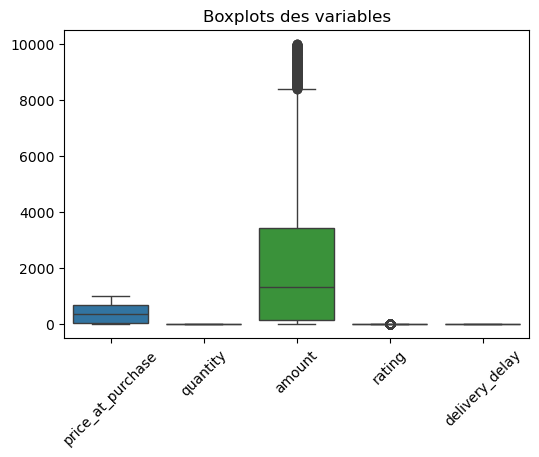

In [29]:
# Visualisation des colonnes numériques
variables = ['price_at_purchase', 'quantity', 'amount', 'rating', 'delivery_delay']

# Création des boxplots pour détecter les valeurs aberrantes
plt.figure(figsize=(6, 4))
sns.boxplot(data=df[variables])
plt.title('Boxplots des variables')
plt.xticks(rotation=45)
plt.show()

    Les variables (quantity, rating, delivery_delay) ont des plages beaucoup plus réduites, ce qui indique une distribution plus concentrée.
    
        price_at_purchase : varie considérablement entre 0 et 999,82 $ avec un écart-type : (std = 324), moyenne supérieur à la médiane => asymétrie à droite, 75% < 675 $, 25% < 32 $. 

        Les ventes totale (amount $) présente la plus grande variabilité, avec de nombreux valeurs extrèmes :  au-delà de 8 000 $, 75% < 3 433 $/ 25% < 125 $. La moyenne 2124.79 $ est largement > à la médiane 1300 $ => Distribution et Asymetrie à droite.
        => A voir de près et detecter les valeurs extrèmes et abbérantes : 

#### Détecter les valeurs abbérantes 

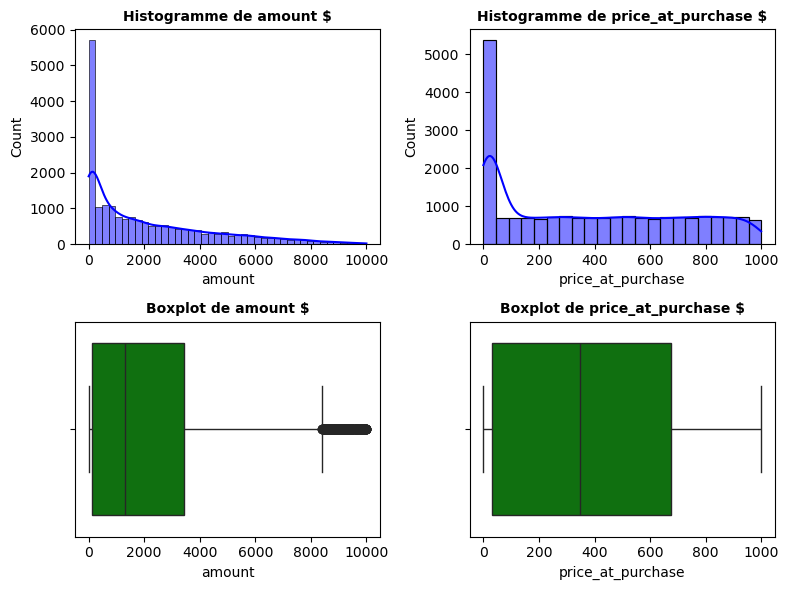

In [32]:
# Focus sur la visualisation des distributions des deux variables (amount et price) 
cols = ['amount', 'price_at_purchase']
plt.figure(figsize=(8, 6))
# Histogrammes
for i, col in enumerate(cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col], kde=True, color="blue")
    plt.title(f"Histogramme de {col} $", fontsize=10, fontweight="bold")
# Boxplots
for i, col in enumerate(cols):
    plt.subplot(2, 2, i+3)
    sns.boxplot(x=df[col], color="green")
    plt.title(f"Boxplot de {col} $", fontsize=10, fontweight="bold")
plt.tight_layout()  # Ajuste l'affichage
plt.show()

    Histogramme : La majorité des montants sont concentrés sous 2 500 $, avec une forte baisse après cette valeur, indiquant une distribution asymétrique vers la droite.
    Boxplot     : La médiane est autour de 2 500 $, mais il y a une grande dispersion avec plusieurs valeurs extrêmes dépassant les 8 000 $, ce qui montre la présence d'achats exceptionnellement à prix élevés ou en grande quantité.

    Conclusion :
    Les montants des transactions varient fortement, avec une majorité sous 2 500 $, mais quelques achats atteignent des valeurs bien plus élevées, ce qui influence la moyenne globale.

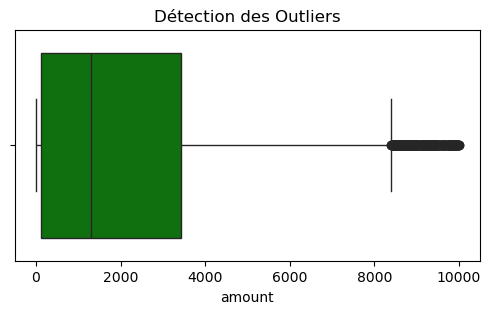

Nombre d'outliers : 315 sur 20000 (1.57%)


In [34]:
# Identifier les outliers avec l’IQR
Q1 = df['amount'].quantile(0.25)  # Premier quartile (25%)
Q3 = df['amount'].quantile(0.75)  # Troisième quartile (75%)
IQR = Q3 - Q1  # Plage interquartile

# Définition des bornes des outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['amount'] < lower_bound) | (df['amount'] > upper_bound)]  # Sélection des valeurs extrêmes
plt.figure(figsize=(6, 3))
sns.boxplot(x=df['amount'], color="green")
plt.title("Détection des Outliers")
plt.show()

print(f"Nombre d'outliers : {len(outliers)} sur {len(df)} ({(len(outliers)/len(df)*100):.2f}%)")

Le nombre des valeurs extrèmes de (amount) totale des ventes, représente 1.75 % du total des enregistrements. A voir, sois à supprimer ou à garder !?

    Les garder si elles représentent des transactions légitimes (pics de ventes sur des produits premium, promotions exceptionnelles…). Elles peuvent refléter des tendances clés plutôt qu’anomalies. 
    Les supprimer si elles sont dues à des erreurs de saisie, des prix incorrects ou des données aberrantes qui faussent l’analyse.

### Analyser les variable catégorielles :

In [37]:
df.groupby('carrier', observed=True)['amount'].agg(['mean', 'max', 'min', 'count']).round(2)

,mean,max,min,count
carrier,,,,
DHL,2147.51,9997.4,0.00,6654
FedEx,2110.08,9996.0,0.02,6697
UPS,2116.86,9971.0,0.00,6649


In [38]:
df.groupby('category', observed=True)['amount'].agg(['mean', 'max', 'min', 'count']).round(2)

,mean,max,min,count
category,,,,
Accessories,2123.51,9972.0,0.04,4631
Electronics,2118.25,9997.4,0.03,7198
Furniture,2153.35,9990.9,0.00,2894
Home & Kitchen,2119.16,9971.0,0.02,5277


In [39]:
df.groupby('transaction_status', observed=True)['amount'].agg(['mean', 'max', 'min', 'count']).round(2)

,mean,max,min,count
transaction_status,,,,
Completed,2127.11,9997.4,0.00,15995
Failed,2099.41,9796.6,0.09,1996
Pending,2131.49,9972.0,0.02,2009


In [40]:
df.groupby('shipment_status', observed=True)['amount'].agg(['mean', 'max', 'min', 'count']).round(2)

,mean,max,min,count
shipment_status,,,,
Cancelled,2040.62,9828.5,0.26,977
Delivered,2153.54,9971.0,0.02,7157
Pending,2085.84,9996.0,0.00,4788
Shipped,2133.67,9997.4,0.00,7078


### Variation des ventes (amount) selon les catégories (shipment_status, transaction_status, category, carrier)


### Statistiques pour shipment_status ###

                    mean     max   min  count
shipment_status                              
Cancelled        2040.62  9828.5  0.26    977
Delivered        2153.54  9971.0  0.02   7157
Pending          2085.84  9996.0  0.00   4788
Shipped          2133.67  9997.4  0.00   7078

### Statistiques pour transaction_status ###

                       mean     max   min  count
transaction_status                              
Completed           2127.11  9997.4  0.00  15995
Failed              2099.41  9796.6  0.09   1996
Pending             2131.49  9972.0  0.02   2009

### Statistiques pour category ###

                   mean     max   min  count
category                                    
Accessories     2123.51  9972.0  0.04   4631
Electronics     2118.25  9997.4  0.03   7198
Furniture       2153.35  9990.9  0.00   2894
Home & Kitchen  2119.16  9971.0  0.02   5277

### Statistiques pour carrier ###

            mean     max   min  count
carrier

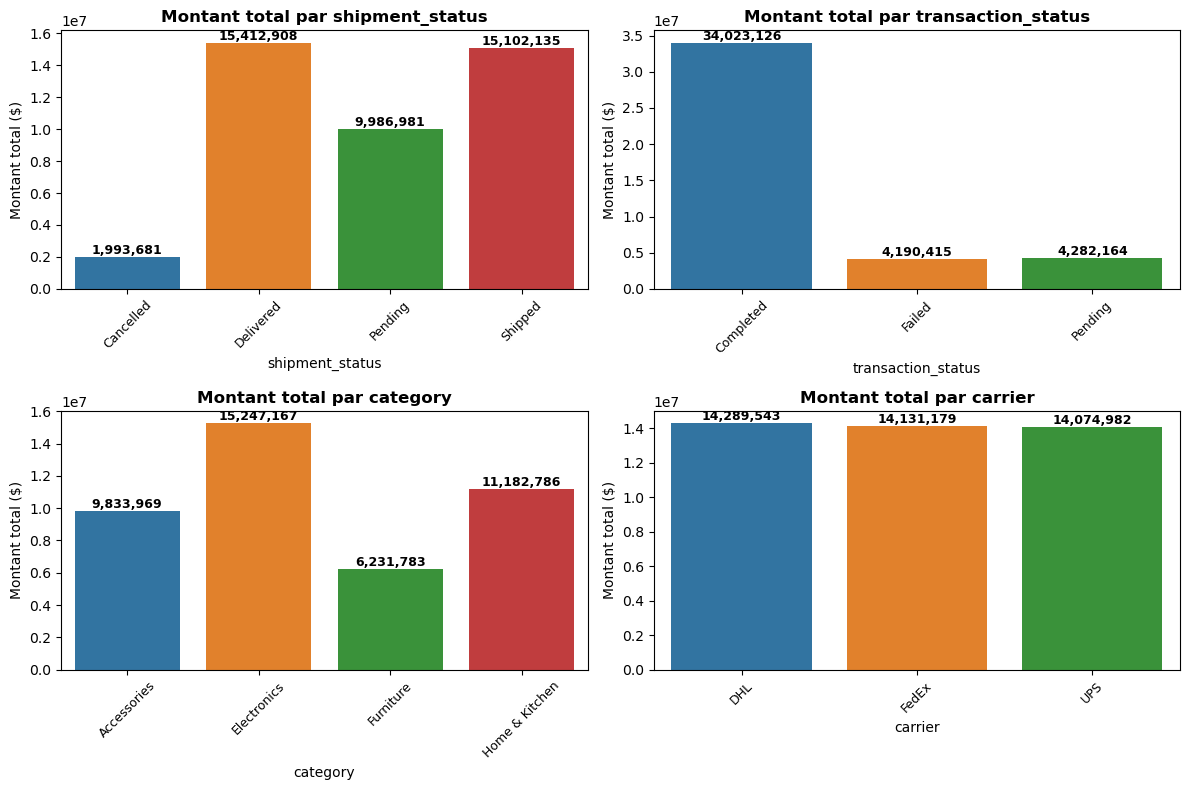

In [42]:
# Liste des variables à grouper
group_cols = ['shipment_status', 'transaction_status', 'category', 'carrier']
# Stocker les agrégations dans un dictionnaire
grouped_data = {col: df.groupby(col, observed=True)['amount'].agg(['mean', 'max', 'min', 'count']).round(2) for col in group_cols}
# Affichage des tables agrégées
for col, data in grouped_data.items():
    print(f"\n### Statistiques pour {col} ###\n")
    print(data)
# Palette de couleurs pour rendre les barplots plus attrayants
palette_colors = ["#4E79A7", "#F28E2B", "#E15759", "#76B7B2"]
# Création de la figure
plt.figure(figsize=(12, 8))
# Générer un barplot pour chaque catégorie avec des couleurs et des étiquettes
for i, col in enumerate(group_cols):
    plt.subplot(2, 2, i + 1)
    sns.barplot(x=df[col], y=df['amount'], estimator=sum, errorbar=None, hue=df[col], legend=False)  # Somme totale par catégorie
    plt.title(f"Montant total par {col}", fontsize=12, fontweight="bold")
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Montant total ($)", fontsize=10)
    plt.xticks(rotation=45, fontsize=9)
    
    # Ajouter les étiquettes de valeurs sur les barres
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height():,.0f}', 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

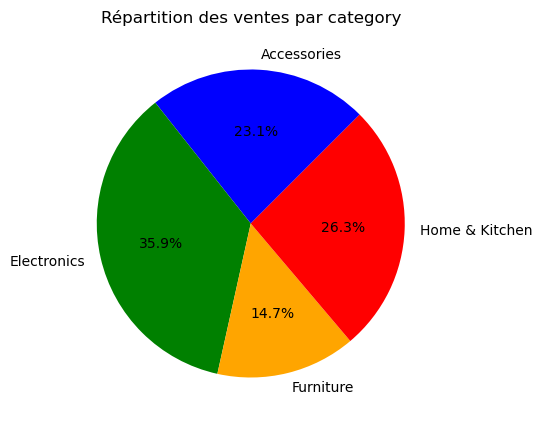

In [43]:
amount_categorie = df.groupby('category', observed=True)['amount'].sum().round(2)
# Création du Pie Chart
plt.figure(figsize=(8, 5))
plt.pie(amount_categorie, labels=amount_categorie.index, autopct='%1.1f%%', startangle=45, colors=['blue', 'green', 'orange', 'red'])
# Ajout du titre
plt.title("Répartition des ventes par category")
plt.show()

### Observation et recommandations sur les varaition des ventes par catégories :

Shipment Status

    Les ventes ($) sont les plus élevées pour les statuts "Delivered" (15 417908) et "Shipped" (15 102135), ce qui est un bon signe.
    Les statuts "Cancelled" (1,993,681) et "Pending" (9,986,981) enregistrent les ventes les plus faibles (à suivre de près les raisons des annulation et le temps d'attente).
Transaction Status

    Le statut "Completed" (34 023126) génère le montant le plus élevé, dominant largement les autres catégories.
    Les statuts "Failed" (4 190415) et "Pending" (4 282164) ont les ventes les plus basses (pas énorme par rapport aux statut valider mais à vérifier et suivre ces transactions pour éviter des perte en chiffre d'affaire).
Category

    Les ventes sont maximales dans les secteurs "Electronics" (15 249167) en tête du classement des ventes (35.9%) et "Home & Kitchen" (26.3 %)occupe la deuxième place avec (11 182786).
    Les catégories "Accessories" (9 833969) (23.1 %) et "Furniture" (14.7 %))(6 231783) affichent les montants des ventes les plus basses.
Carrier

    Les ventes sont relativement équilibrées entre les Transporteurs :  DHL (14 289843), FedEx (14 131179) et UPS (14 074982).
    La différence de ventes entre les transporteurs est minime, suggérant une répartition homogène.


La baisse importante observée dans certaines catégories pourrait indiquer des problèmes de demande, de logistique ou de conversion !?.

#### Ventes par type de produits :

In [46]:
# Calculer le prix de vente moyen par produit
mean_price_products = df.groupby('product_name', observed=True)['price_at_purchase'].mean().round(2)
# Calcul de la moyenne ventes (amount) par produit
mean_amount_products = df.groupby('product_name', observed=True)['amount'].mean().round(2)
# Trier les produits du plus cher au moins cher
sorted_poruduct = mean_amount_products.sort_values(ascending=False)
# Extraire les 5 produits les plus chers et les 5 moins chers
Top5_products = sorted_poruduct.head(5)
Flop5_products = sorted_poruduct.tail(5)
print("Top 5 produits les plus chers:")
print(Top5_products)
print("\nTop 5 produits les moins chers:")
print(Flop5_products)
# print(mean_price_products)

Top 5 produits les plus chers:
product_name
Microphone            2353.24
Rice Cooker           2293.76
Standing Desk         2293.64
Storage Containers    2260.76
Office Chair          2243.29
Name: amount, dtype: float64

Top 5 produits les moins chers:
product_name
Throw Pillows         1990.19
Laptop Sleeve         1961.38
Wireless Presenter    1932.87
Electric Kettle       1924.09
Storage Shelf         1917.52
Name: amount, dtype: float64


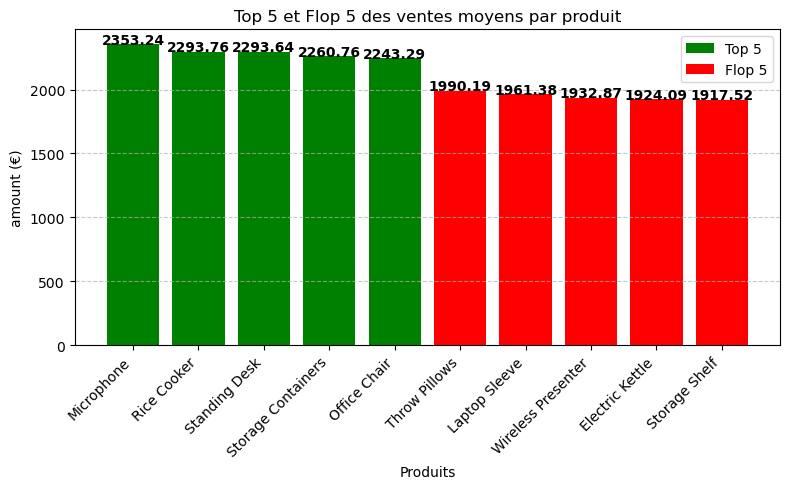

In [47]:
# Création du graphique
plt.figure(figsize=(8, 5))
# Tracé des produits les plus chers
plt.bar(Top5_products.index, Top5_products.values, color='green', label="Top 5")
# Tracé des produits les moins chers
plt.bar(Flop5_products.index, Flop5_products.values, color='red', label="Flop 5")
# Ajout des étiquettes sur les barres
for i, v in enumerate(Top5_products.values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=10, fontweight='bold')

for i, v in enumerate(Flop5_products.values):
    plt.text(i + len(Top5_products), v + 5, str(v), ha='center', fontsize=10, fontweight='bold')
# Ajout de titres et labels
plt.title("Top 5 et Flop 5 des ventes moyens par produit")
plt.ylabel("amount (€)")
plt.xlabel("Produits")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# Affichage du graphique
plt.show()

#### Observations des ventes par produits :
    Les produits qui généres le plus de ventes sont dominés par des articles de bureau et électroménagers haut de gamme, avec le Microphone en tête à 2 353,24 $. 
    Les produits avec des ventes les plus basse sont principalement des accessoires et objets de maison, avec le Throw Pillow le plus bas des ventes avec 1 990,19. 
    L’écart des ventes entre le haut et le bas du classement reste modéré, suggérant une répartition relativement homogène. (selon le pix moyen et la quantité de ventes).

In [49]:
df.columns

Index(['order_item_id', 'order_id', 'product_id', 'customer_id', 'last_name',
       'price_at_purchase', 'quantity', 'amount', 'rating', 'category',
       'product_name', 'transaction_status', 'carrier', 'shipment_status',
       'supplier_name', 'order_date', 'shipment_date', 'delivery_date',
       'delivery_delay'],
      dtype='object')

### Ventes par clients :

In [51]:
# Calcul du prix moyen d'achat par client
price_customer = df.groupby('last_name', observed=True)['price_at_purchase'].mean().round(2)
# Trier les clients par montant dépensé (du plus élevé au plus bas)
sorted_customers = price_customer.sort_values(ascending=False)
# Extraire les 5 clients qui dépensent le plus et ceux qui dépensent le moins
Top5_customers  = sorted_customers.head(5)
Flop5_customers = sorted_customers.tail(5)
# Affichage des résultats
print("Top 5 Clients :")
print(Top5_customers)
print("\n Flop 5 Clients :")
print(Flop5_customers)

Top 5 Clients :
last_name
Samuel     448.17
Frank      427.62
Cynthia    424.07
Adam       420.21
Dennis     416.81
Name: price_at_purchase, dtype: float64

 Flop 5 Clients :
last_name
Gerald       365.24
Terry        362.08
Christina    359.90
Sophia       355.84
Jackson      355.30
Name: price_at_purchase, dtype: float64


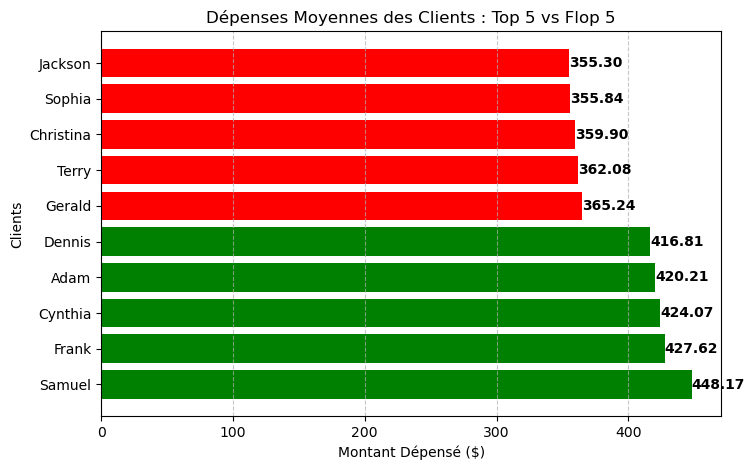

In [52]:
# Fusionner les meilleurs et les moins bons clients
customers_data = pd.concat([Top5_customers, Flop5_customers])
# Création du graphique
plt.figure(figsize=(8, 5))
plt.barh(customers_data.index, customers_data.values, color=["green"] * 5 + ["red"] * 5)
# Ajout des étiquettes directement sur les barres
for index, value in zip(customers_data.index, customers_data.values):
    plt.text(value, index, f"{value:.2f}", va='center', fontsize=10, fontweight='bold', color="black")
# Ajout du titre et labels
plt.title("Dépenses Moyennes des Clients : Top 5 vs Flop 5")
plt.xlabel("Montant Dépensé ($)")
plt.ylabel("Clients")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

### Analyse des dépenses clients : 
    Les clients les plus dépensiers affichent des montants supérieurs à 400 $, montrant une forte fidélité et un engagement commercial important. 
    En revanche, les clients les moins dépensiers, sous 370 $, pourraient bénéficier d'actions marketing pour stimuler leurs achats.

### Vente par fournisseurs

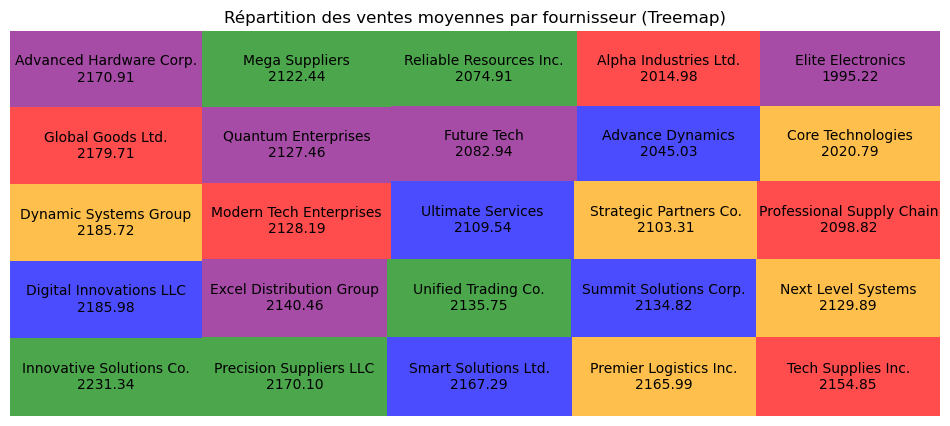

In [55]:
import squarify
mean_amount_supplier = df.groupby('supplier_name', observed=True)['amount'].mean().round(2)
# Trier les fournisseurs par montant des ventes moyennes (du plus élevé au plus bas)
sorted_supplier = mean_amount_supplier.sort_values(ascending=False)
# Création du Treemap
plt.figure(figsize=(12, 5))
squarify.plot(sizes=sorted_supplier.values, 
              label=[f"{name}\n{value:.2f}" for name, value in zip(sorted_supplier.index, sorted_supplier.values)], 
              alpha=0.7, color=["green", "blue", "orange", "red", "purple"])
# Ajout du titre et suppression des axes
plt.title("Répartition des ventes moyennes par fournisseur (Treemap)")
plt.axis('off')
plt.show()

### Analyse des ventes moyennes par fournisseur :

    Les premiers fournisseurs affichent des ventes élevées, dominées par Innovative Solutions Co. (2231.34 $) et Next Level Systems (2129.89 $), ce qui indique une forte demande pour leurs produits.
    Les fournisseurs du milieu ont des ventes relativement équilibrées, comme Quantum Enterprises (2127.46 $) et Mega Suppliers (2122.44 $), suggérant une répartition homogène. 
    Les derniers fournisseurs tels que Elite Electronics (1995.22 $) et Core Technologies (2020.79 $) enregistrent des ventes plus faibles, nécessitant une analyse pour optimiser leurs performances

In [57]:
# Groupement des ventes par category et produits
category_product_sales = df.groupby(['category', 'product_name'], observed=True)['amount'].sum().round(2)
# Affichage des résultats triés
print("Ventes totales par category Produit :")
print(category_product_sales.sort_values(ascending=False).head(5))  # Affichage des 5 premiers
print("***********************************************************")
print(category_product_sales.sort_values(ascending=False).tail(5))  # Affichage des 5 derniers

Ventes totales par category Produit :
category        product_name   
Electronics     4K Monitor         1028666.50
                Microphone          981300.29
Furniture       Standing Desk       974797.23
Home & Kitchen  Kitchen Blender     932734.20
                Air Purifier        924883.08
Name: amount, dtype: float64
***********************************************************
category     product_name      
Accessories  Smartphone Case       741189.85
             Screen Protector      733785.49
Electronics  Wireless Earbuds      732128.73
             WiFi Router           724296.15
             Wireless Presenter    697765.51
Name: amount, dtype: float64


## Evolution des ventes dans le temps

In [59]:
%matplotlib inline

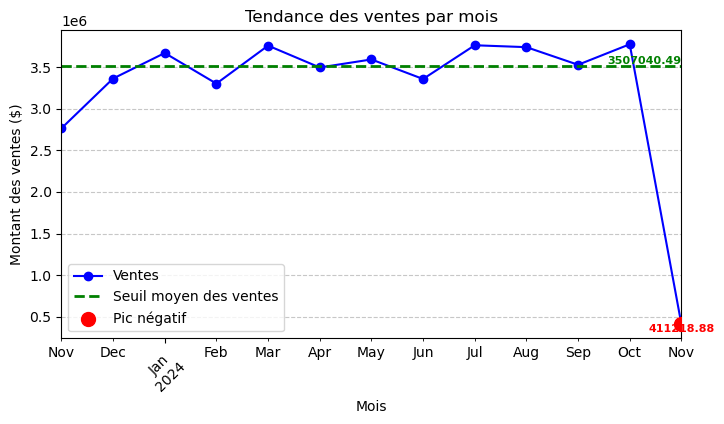

 Ventes total (amount) par mois(order_date
2023-11    2763201.95
2023-12    3360869.91
2024-01    3667447.62
2024-02    3300225.42
2024-03    3756172.48
2024-04    3493861.41
2024-05    3590164.64
2024-06    3355548.13
2024-07    3760470.93
2024-08    3737818.32
2024-09    3526269.73
2024-10    3772435.39
2024-11     411218.88
Freq: M, Name: amount, dtype: float64)
Seuil moyen des ventes : 3507040.49
Pic négatif des ventes  : 2024-11
Vente la plus basse est : 411218.88


In [60]:
# Agrégation des ventes par mois
df['order_date'] = pd.to_datetime(df['order_date'])
sales_trend = df.groupby(df['order_date'].dt.to_period("M"))['amount'].sum()
# Création du graphique
plt.figure(figsize=(8, 4))
ax = sales_trend.plot(color='blue', marker='o', linestyle='-', label="Ventes")
# Identification du pic négatif (mois avec la plus faible vente)
min_month = sales_trend.idxmin()
min_value = sales_trend.min()
# Définir le seuil des ventes habituelles (moyenne des ventes hors pic négatif)
threshold = sales_trend[sales_trend.index != min_month].mean()
# Tracer la ligne horizontale
plt.axhline(y=threshold, color='green', linestyle='--', linewidth=2, label="Seuil moyen des ventes")
# Ajouter une annotation pour indiquer le seuil
plt.text(sales_trend.index[-1], threshold, f"{threshold:.2f}", ha='right', va='bottom', fontsize=8, color='green', fontweight='bold')
# Mettre en évidence le pic négatif en rouge
plt.scatter(min_month, min_value, color='red', s=100, label="Pic négatif", zorder=3)
plt.text(min_month, min_value, f"{min_value:.2f}", ha='center', va='top', fontsize=8, color='red', fontweight='bold')
# Ajout de titres et labels
plt.title("Tendance des ventes par mois")
plt.xlabel("Mois")
plt.ylabel("Montant des ventes ($)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show(block=True)

print(f" Ventes total (amount) par mois({sales_trend})")
print(f"Seuil moyen des ventes : {threshold:.2f}")
print(f"Pic négatif des ventes  : {min_month}")
print(f"Vente la plus basse est : {min_value}")

#### Observation et recommandations sur les ventes par mois :

Les ventes étaient relativement stables avec des fluctuations normales jusqu'à octobre 2024.

En novembre 2024, on constate une baisse drastique des ventes pic négatif (à 411 218,88 $) bien en dessous des ventes et seuil moyen des autres mois (3 507040,49).

Il serait intéressant d’explorer les causes possibles : saisonnalité, baisse de la demande, problème logistique ou événement externe !?

# 2_Prédiction des tendance des ventes

### Relations entre les variables (Matrice corrélation)

#### Martrice de corrélation, entre tout les variables :

                    price_at_purchase  quantity    amount    rating  category  \
price_at_purchase            1.000000  0.324979  0.778920 -0.000855 -0.001646   
quantity                     0.324979  1.000000  0.723404  0.023432  0.000911   
amount                       0.778920  0.723404  1.000000  0.017310  0.000568   
rating                      -0.000855  0.023432  0.017310  1.000000 -0.012575   
category                    -0.001646  0.000911  0.000568 -0.012575  1.000000   
product_name                -0.002050  0.003000  0.002256  0.061955 -0.037288   
transaction_status          -0.006321  0.005975 -0.000801 -0.015054 -0.006468   
carrier                     -0.001083 -0.005049 -0.005418 -0.006666  0.003594   
shipment_status              0.004708 -0.002813  0.000493 -0.057759 -0.006681   
supplier_name                0.000582  0.003401  0.004389  0.076806 -0.220372   
delivery_delay               0.003650  0.003367  0.004776  0.001215 -0.003118   

                    product

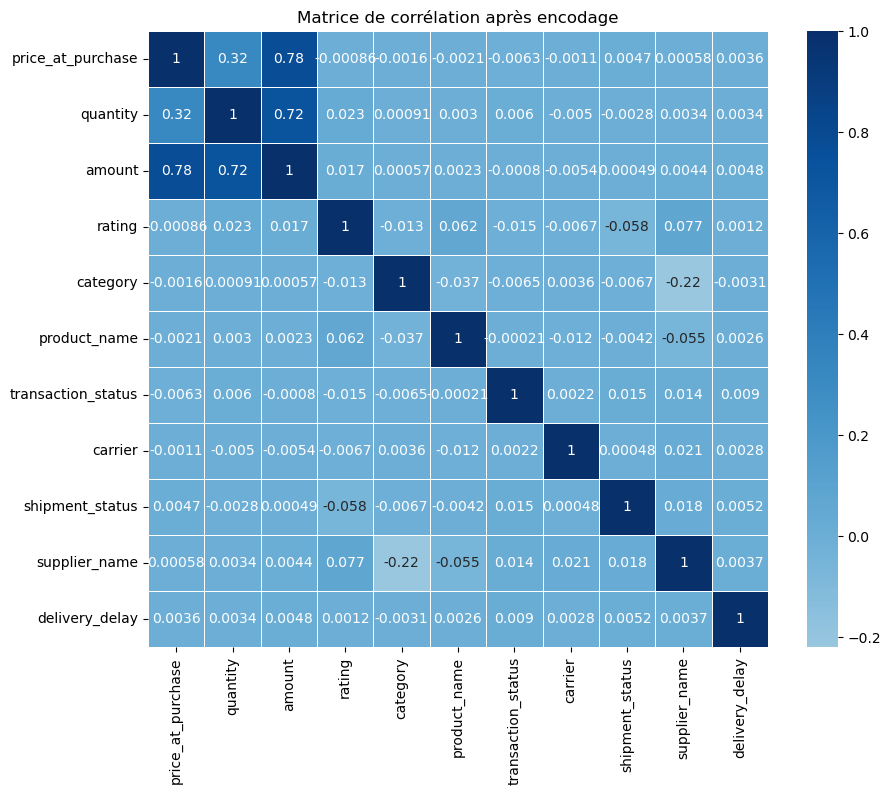

In [165]:
# Encoder les catégories en valeurs numériques
df_encoded = df.copy()  # Créer une copie pour éviter d'affecter les données originales

cols_to_encode = ['category', 'product_name', 'transaction_status', 'carrier', 'shipment_status', 'supplier_name']

for col in cols_to_encode:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes  # Convertir en codes numériques

# Calcul de la matrice de corrélation
df_corr = df_encoded[['price_at_purchase', 'quantity', 'amount', 'rating', 'category',
                      'product_name', 'transaction_status', 'carrier', 'shipment_status',
                      'supplier_name', 'delivery_delay']].corr(method='pearson')

print(df_corr)
# Affichage de la heatmap
plt.figure(figsize=(10, 8))  # Taille ajustée pour meilleure lisibilité
sns.heatmap(df_corr, annot=True, cmap="Blues", center=0, linewidths=0.5)
plt.title("Matrice de corrélation après encodage")
plt.show()

### Analyse des corrélations fortes dans tes données :

Corrélation positive forte :

    price_at_purchase et amount (0.78) => Les montants des ventes sont fortement liés aux prix d’achat.
    quantity et amount (0.72)          => Plus la quantité achetée est élevée, plus le montant total est important.

Corrélation négative modérée :
    
    category et supplier_name (-0.22) => Indique une tendance à certaines catégories étant liées à des fournisseurs spécifiques.

#### Interprétation : 
    
    => Les montants des ventes dépendent fortement du prix et de la quantité des produits achetés, ce qui est un indicateur clé pour l'optimisation des stratégies de tarification et de stock. 
    => La corrélation négative entre catégorie et fournisseur pourrait indiquer des regroupements spécifiques dans l’approvisionnement.

### Corrélation entre des colonnes numériques

                     amount  price_at_purchase  quantity    rating  \
amount             1.000000           0.778920  0.723404  0.017310   
price_at_purchase  0.778920           1.000000  0.324979 -0.000855   
quantity           0.723404           0.324979  1.000000  0.023432   
rating             0.017310          -0.000855  0.023432  1.000000   
delivery_delay     0.004776           0.003650  0.003367  0.001215   

                   delivery_delay  
amount                   0.004776  
price_at_purchase        0.003650  
quantity                 0.003367  
rating                   0.001215  
delivery_delay           1.000000  


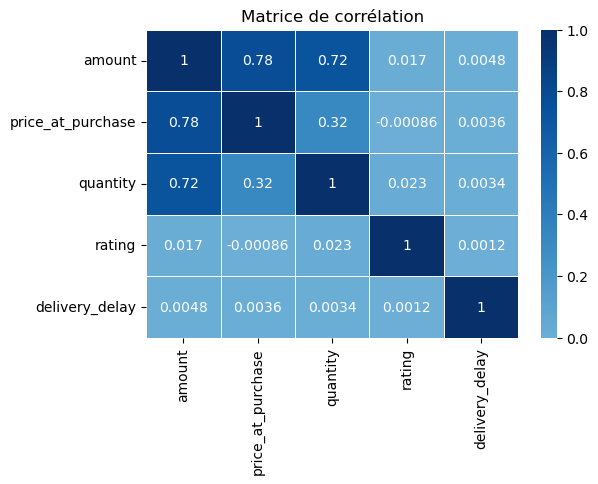

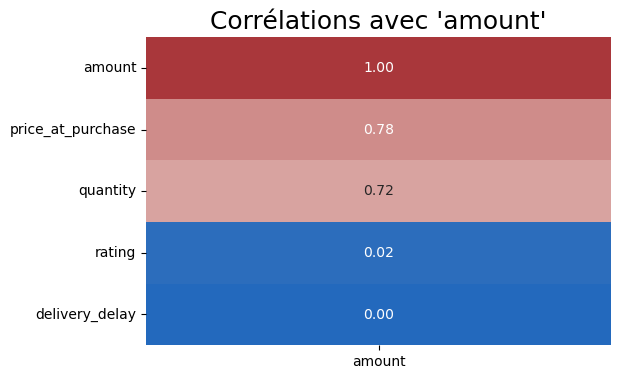

In [163]:
# Sélectionner les colonnes à analyser
df_corr = df[['amount', 'price_at_purchase', 'quantity',  'rating', 'delivery_delay']].corr(method='pearson')
print(df_corr)

# Focalisation uniquement sur les corrélations avec 'duree_moyenne_sejour'
target_corr = df_corr[['amount']].sort_values(by='amount', ascending=False)

# Création de la heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_corr, annot=True, cmap="Blues", center=0, linewidths=0.5)

plt.title("Matrice de corrélation")
plt.show()

#  Heatmap focalisée uniquement sur la corrélation avec 'amount'
plt.figure(figsize=(6, 4))
sns.heatmap(target_corr, annot=True, fmt=".2f", cmap="vlag", cbar=False)
plt.title("Corrélations avec 'amount'", fontsize=18)
plt.show()

Forte corrélation positives des ventes total avec les prix des ventes et la quantité vendues : indiquant que les produits plus chers génèrent des revenus plus élevés et confirmant que les volumes jouent un rôle clé.

Impact modéré voir insignifiantes du délai de livraison et pas d'effet notable des avis client sur les ventes tatales. 

## A_Prédir les tendances de ventes futures ?

•	Collecte de données
    
    o	Dataset :    Connexion directement avec la base de données online_shop.
    o	Features: 	 à définir (x = 'price_at_purchase', 'quantity', 'rating', 'delivery_delay') 
    o	Target  : 	 amount    (y = variable dépendante)
     
•	Choix du modèle 

    Modèle de modèle Random Forest Regressor pour prédir les ventes futures en fonction de plusieurs variables (rating, quantité,....)

•	Fractionner (split) le jeu de données : Diviser les données en train (80%) et test (20%) pour éviter le surapprentissage

•	Entraîner le modèle sur des données historiques.

•	Application du modèle

 ***Évaluation du modèle***
Coefficient de détermination (R²) : 1.0000
MAE  (Erreur Absolue Moyenne)     : 1.62
RMSE (Erreur Quadratique Moyenne) : 2.94


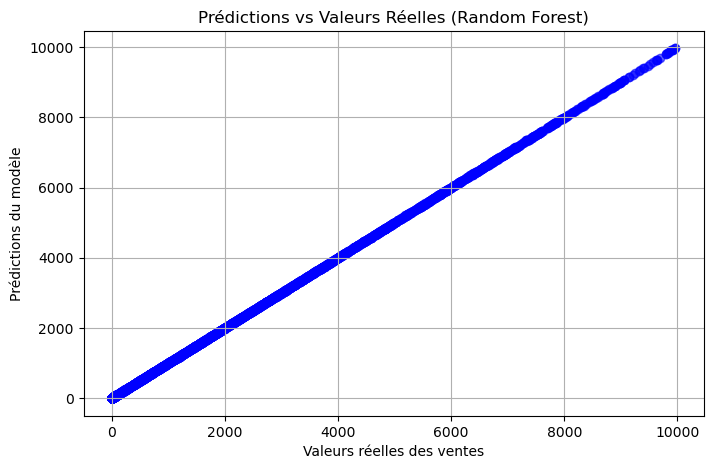

In [71]:
# Sélection des variables
features = ['price_at_purchase', 'quantity', 'rating', 'delivery_delay']
target   = 'amount'

# Séparation en jeu d'entraînement et de test
X = df[['price_at_purchase', 'quantity', 'rating', 'delivery_delay']]
y = df['amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = rf_model.predict(X_test)

# Évaluation du modèle
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f" ***Évaluation du modèle***")
print(f"Coefficient de détermination (R²) : {r2:.4f}")
print(f"MAE  (Erreur Absolue Moyenne)     : {mae:.2f}")
print(f"RMSE (Erreur Quadratique Moyenne) : {rmse:.2f}")

# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue")
plt.xlabel("Valeurs réelles des ventes")
plt.ylabel("Prédictions du modèle")
plt.title("Prédictions vs Valeurs Réelles (Random Forest)")
plt.grid(True)
plt.show()


#### Interprétation des résultats du modèle :

    R² = 1.0000 indique une prédiction parfaite, mais cela peut suggérer un surajustement où le modèle apprend trop bien les données d'entraînement.
    MAE et RMSE faibles (1.62 et 2.94) montrent des erreurs minimales, ce qui peut être bon, mais il est essentiel de vérifier que le modèle généralise bien.
   
### À tester sur des nouvelles données : Il faudrait valider sur un ensemble de test totalement indépendant pour s'assurer que le modèle ne mémorise pas simplement les données d'origine

In [73]:
from sklearn.model_selection import cross_val_score

# Initialisation du modèle avec les meilleurs hyperparamètres trouvés
rf_best = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
# Validation croisée (k=5)
cv_scores = cross_val_score(rf_best, X, y, cv=5, scoring='r2')
# Affichage des résultats
print(f" Scores R² de la validation croisée : {cv_scores}")
print(f" Moyenne R²                         : {np.mean(cv_scores):.4f}")
print(f" Écart-type des scores              : {np.std(cv_scores):.4f}")


 Scores R² de la validation croisée : [0.99999827 0.99999847 0.99999806 0.99999845 0.99999847]
 Moyenne R²                         : 1.0000
 Écart-type des scores              : 0.0000


#### R² moyen de 1.0000 avec un écart-type de 0.0000 signifie que le modèle ajuste parfaitement nos données sur toutes les validations croisées.

In [75]:
#  Définition de la fonction de prédiction
def predict_future_sales(rf_model, new_data):
    """
    Prédit les ventes futures à partir du modèle Random Forest
    :param model: Modèle entraîné (RandomForestRegressor)
    :param new_data: Nouvelles données sous forme de DataFrame
    :return: Prédictions des ventes
    """
    predictions = rf_model.predict(new_data)
    return predictions

#  Exemple d’application avec des données fictives
new_sample_data = np.array([[300, 3, 2.75, 5]])  # Exemple de nouvelles données ['price_at_purchase', 'quantity', 'rating', 'delivery_delay']
predicted_sales = predict_future_sales(rf_model, new_sample_data)

# Affichage du résultat
print(f" Prédiction des ventes futures : {predicted_sales[0]:.2f} $")

 Prédiction des ventes futures : 900.97 $


C:\Users\sefas\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [76]:
def predict_future_sales(rf_model, new_data):
    try:
        predictions = rf_model.predict(new_data)
        return predictions
    except Exception as e:
        print(f"Erreur lors de la prédiction : {e}")
        return None
# Exemple de nouvelles données
new_sample_data = np.array([[300, 3, 2.75, 5]])  
predicted_sales = predict_future_sales(rf_model, new_sample_data)

# Vérification et exportation des résultats
if predicted_sales is not None:
    # Création d'un DataFrame avec les résultats
    df = pd.DataFrame(new_sample_data, columns=['price_at_purchase', 'quantity', 'rating', 'delivery_delay'])
    df['predicted_sales'] = predicted_sales

    # Exportation vers CSV
    df.to_csv('predictions.csv', index=False)
    print("Prédictions exportées dans 'predictions.csv'")

Prédictions exportées dans 'predictions.csv'


C:\Users\sefas\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Prédiction des ventes futures mensuelle avec Random Forest

In [101]:
df.columns

Index(['order_item_id', 'order_id', 'product_id', 'customer_id', 'last_name',
       'price_at_purchase', 'quantity', 'amount', 'rating', 'category',
       'product_name', 'transaction_status', 'carrier', 'shipment_status',
       'supplier_name', 'order_date', 'shipment_date', 'delivery_date'],
      dtype='object')

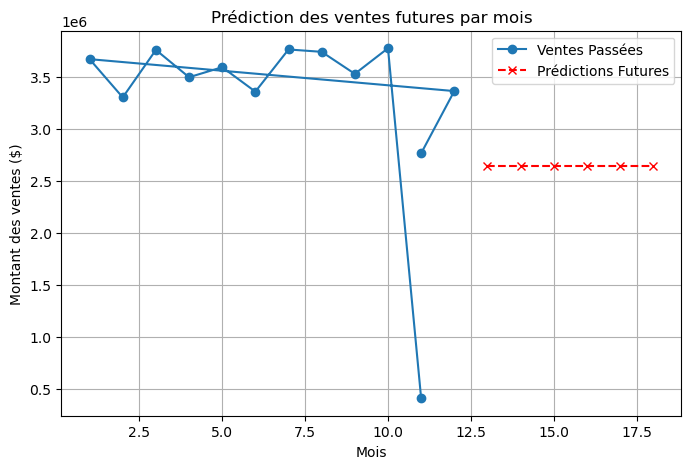

In [103]:

# Préparation des données
df['order_date']  = pd.to_datetime(df['order_date'])    # Conversion en format datetime
df['month']       = df['order_date'].dt.to_period('M')  # Extraction du mois
monthly_sales     = df.groupby('month')['amount'].sum().reset_index()

# Transformation des données pour la prédiction
monthly_sales['month']     = monthly_sales['month'].astype(str)               # Conversion en string
monthly_sales['month_num'] = pd.to_datetime(monthly_sales['month']).dt.month  # Conversion en numérique

# Séparation des données
X = monthly_sales[['month_num']]
y = monthly_sales['amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Prédiction des ventes futures
future_months = pd.DataFrame({'month_num': np.arange(X['month_num'].max() + 1, X['month_num'].max() + 7)})
future_sales = rf_model.predict(future_months)

# Visualisation des prédictions
plt.figure(figsize=(8, 5))
plt.plot(monthly_sales['month_num'], monthly_sales['amount'], label="Ventes Passées", marker='o')
plt.plot(future_months['month_num'], future_sales, label="Prédictions Futures", marker='x', linestyle="dashed", color="red")
plt.xlabel("Mois")
plt.ylabel("Montant des ventes ($)")
plt.title("Prédiction des ventes futures par mois")
plt.legend()
plt.grid()
plt.show()

## Analyse des résultats de la prédiction des ventes futures :

    Stabilité des ventes prédictives : Le modèle prévoit une tendance stable autour de 3,5 millions de dollars après le 10e mois, suggérant une continuité sans variations majeures.
    Anomalie détectée : On observe une forte chute des ventes en dessous de 0,5 million de dollars au 10e mois dans les données historiques, ce qui pourrait indiquer un événement impactant (crise, saisonnalité, changement de marché).
    
### Précaution : 

    Bien que les prédictions affichent une reprise normale des ventes, il pourrait être pertinent d'explorer les causes de la chute passée pour s'assurer que le modèle prend en compte tous les facteurs clés.

### Recommandation : Vérifier si cette baisse était temporaire ou structurelle et, si nécessaire, ajuster les prédictions en intégrant plus de variables explicatives.

In [155]:
df.columns

Index(['order_item_id', 'order_id', 'product_id', 'customer_id', 'last_name',
       'price_at_purchase', 'quantity', 'amount', 'rating', 'category',
       'product_name', 'transaction_status', 'carrier', 'shipment_status',
       'supplier_name', 'order_date', 'shipment_date', 'delivery_date',
       'month', 'order_month', 'shipment_month', 'delivery_delay'],
      dtype='object')

# B_Prédiction de la durée de livraison 

•	Collecte de données
    
    o	Dataset :    Connexion directement avec la base de données online_shop.
    o	Features: 	 à définir (x = 'price_at_purchase', 'quantity', 'carrier', 'order_month', 'shipment_month') 
    o	Target  : 	 delivery_date   (y = variable dépendante)

Coefficient de détermination (R²) : -0.0071
MAE (Erreur Absolue Moyenne)      : 1.79
RMSE (Erreur Quadratique Moyenne) : 2.08


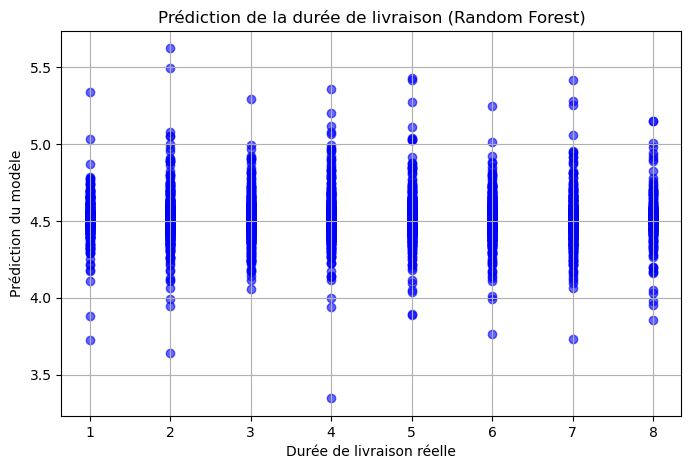

In [201]:
# Vérification et conversion des dates
date_columns = ['order_date', 'shipment_date', 'delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')  # Coerce pour gérer les erreurs
# Suppression des lignes avec des dates manquantes
df = df.dropna(subset=['order_date', 'shipment_date', 'delivery_date'])
# Extraction des caractéristiques temporelles
df['order_month']    = df['order_date'].dt.month
df['shipment_month'] = df['shipment_date'].dt.month
# Correction : Calcul de la durée de livraison
df['delivery_delay'] = (df['delivery_date'] - df['shipment_date']).dt.days
# Suppression des valeurs incohérentes (exemple : livraison négative ou trop longue)
df = df[df['delivery_delay'] >= 0]
# Sélection des variables pertinentes
features = ['price_at_purchase', 'quantity', 'carrier', 'order_month', 'shipment_month']
target   = 'delivery_delay'  # Correction : prévision du délai de livraison
# Encodage des catégories
df_encoded = df.copy()
df_encoded['carrier'] = df_encoded['carrier'].astype('category').cat.codes
# Séparation des données en jeu d'entraînement et de test
X = df_encoded[features]
y = df_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Entraînement du modèle
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
# Prédiction sur le jeu de test
y_pred = rf_model.predict(X_test)
# Évaluation du modèle
r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Coefficient de détermination (R²) : {r2:.4f}")
print(f"MAE (Erreur Absolue Moyenne)      : {mae:.2f}")
print(f"RMSE (Erreur Quadratique Moyenne) : {rmse:.2f}")
# Visualisation des prédictions
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue")
plt.xlabel("Durée de livraison réelle")
plt.ylabel("Prédiction du modèle")
plt.title("Prédiction de la durée de livraison (Random Forest)")
plt.grid(True)
plt.show()

#### Analyse des prédictions de la durée de livraison :

    R² négatif (-0.0071) : Indique que le modèle est moins performant qu'une prédiction moyenne (le modèle introduit de l’erreur supplémentaire et et aggrave la précision par rapport à une simple estimation moyenne). 
    MAE  de 1.79 jours   : En moyenne, les prédictions s'écartent de presque 2 jours.  
    RMSE de 2.08 jours   : Erreurs plus élevées sur certaines prédictions, nécessitant une amélioration.


In [189]:
from xgboost import XGBRegressor
# Préparation des données
df['order_date']    = pd.to_datetime(df['order_date'])
df['shipment_date'] = pd.to_datetime(df['shipment_date'])
df['delivery_date'] = pd.to_datetime(df['delivery_date'])
# Extraction des caractéristiques temporelles
df['order_month']    = df['order_date'].dt.month
df['shipment_month'] = df['shipment_date'].dt.month
# Sélection des variables pertinentes
features = ['price_at_purchase', 'quantity', 'category', 'carrier', 'order_month', 'shipment_month']
target   = 'delivery_delay'
# Encodage des catégories
df_encoded = df.copy()
for col in ['category', 'carrier']:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes
# Séparation des données en jeu d'entraînement et de test
X = df_encoded[features]
y = df_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Entraînement du modèle XGBoost
xgb_model = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
# Prédiction sur le jeu de test
y_pred = xgb_model.predict(X_test)
# Évaluation du modèle
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f" Coefficient de détermination (R²) : {r2:.4f}")
print(f"MAE (Erreur Absolue Moyenne)       : {mae:.2f}")
print(f"RMSE (Erreur Quadratique Moyenne)  : {rmse:.2f}")

 Coefficient de détermination (R²) : -0.1115
MAE (Erreur Absolue Moyenne)       : 1.85
RMSE (Erreur Quadratique Moyenne)  : 2.18


#### Analyse des résultats du modèle XGBoost pour la prédiction de la durée de livraison :

R² négatif (-0.1115) : Indique que le modèle ne parvient pas à expliquer correctement la variance des données. Il est donc moins performant qu'une simple moyenne des délais de livraison.

MAE (1.85 jours) et RMSE (2.18 jours) : Montre que le modèle génère une erreur moyenne de près de 2 jours, ce qui peut être problématique pour une prédiction précise.

Cause la plus probables: Les facteurs influençant la livraison sont absents (ex. logistique, météo, distances livraison, ....).

### Model regression linéaire :

Coefficient de détermination (R²) : -0.0019
MAE (Erreur Absolue Moyenne)      : 1.79 jours
RMSE (Erreur Quadratique Moyenne) : 2.07 jours


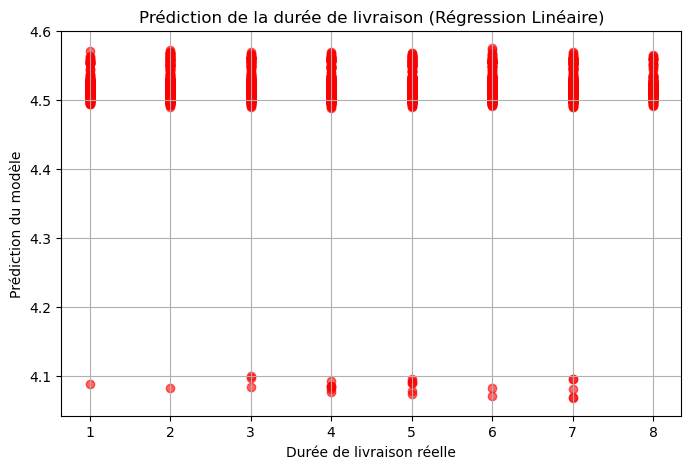

In [210]:
# Conversion des dates avec gestion des erreurs
date_columns = ['order_date', 'shipment_date', 'delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
# Suppression des lignes avec des valeurs manquantes
df = df.dropna(subset=['order_date', 'shipment_date', 'delivery_date'])
# Extraction des caractéristiques temporelles
df['order_month']    = df['order_date'].dt.month
df['shipment_month'] = df['shipment_date'].dt.month
# Calcul de la durée de livraison
df['delivery_delay'] = (df['delivery_date'] - df['shipment_date']).dt.days
# Suppression des valeurs incohérentes (délai négatif ou trop grand)
df = df[df['delivery_delay'] >= 0]
# Sélection des variables pertinentes
features = ['price_at_purchase', 'quantity', 'carrier', 'order_month', 'shipment_month']
target   = 'delivery_delay'
# Encodage des catégories (conversion des transporteurs en numérique)
df_encoded = df.copy()
df_encoded['carrier'] = df_encoded['carrier'].astype('category').cat.codes
# Séparation des données en jeu d'entraînement et de test
X = df_encoded[features]
y = df_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#  Entraînement du modèle de régression linéaire
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
# Prédiction sur le jeu de test
y_pred = lr_model.predict(X_test)
# Évaluation du modèle
r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Coefficient de détermination (R²) : {r2:.4f}")
print(f"MAE (Erreur Absolue Moyenne)      : {mae:.2f} jours")
print(f"RMSE (Erreur Quadratique Moyenne) : {rmse:.2f} jours")
# Visualisation des prédictions
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color="red")
plt.xlabel("Durée de livraison réelle")
plt.ylabel("Prédiction du modèle")
plt.title("Prédiction de la durée de livraison (Régression Linéaire)")
plt.grid(True)
plt.show()

##### Le modèle de régression linéaire ne semble pas beaucoup améliorer les résultats par rapport à Random Forest.

    R² (-0.0019)   : Toujours proche de zéro, indiquant que le modèle ne capte pas bien la relation entre les variables et le délai de livraison. 
    MAE et RMSE similaires : La précision reste la même, donc une approche linéaire ne semble pas mieux adapter les données. 
   
## Recommandations: 
    
Il faudrait inclure des variables plus pertinentes (ex. conditions logistiques, saisonnalité, fournisseur, distances livrasion, saisons, l'heure de commande...) et tester un modèle plus adapté aux données temporelles.